In [2]:
# Import necessary packages
import numpy as np
from numpy import dtype
import netCDF4 as nc
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn
from scipy import stats,signal
from scipy.spatial.distance import cdist
import datetime as dt
from datetime import date
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.mpl.ticker as cticker
import cftime
import dask
import collections
import scipy as scipy
from scipy.signal import detrend
from scipy import stats,signal
import cfgrib
import os
import glob
from scipy.stats import pearsonr
import matplotlib.dates as mdates
from collections import Counter
import matplotlib.lines as mlines

In [3]:
# Define the start and end years
start_year = 1990
end_year = 2022

# Generate all dates in April and May for each year from 1981 to 2023
dates = []
for year in range(start_year, end_year + 1):
    january_dates = [dt.date(year, 1, day) for day in range(1, 32)]
    february_dates = [dt.date(year, 2, day) for day in range(1, 29)]
    march_dates = [dt.date(year, 3, day) for day in range(1, 32)]
    april_dates = [dt.date(year, 4, day) for day in range(1, 31)]
    may_dates = [dt.date(year, 5, day) for day in range(1, 32)]
    june_dates = [dt.date(year, 6, day) for day in range(1, 31)]
    july_dates = [dt.date(year, 7, day) for day in range(1, 32)]
    august_dates = [dt.date(year, 8, day) for day in range(1, 32)]
    september_dates = [dt.date(year, 9, day) for day in range(1, 31)]
    october_dates = [dt.date(year, 10, day) for day in range(1, 32)]
    november_dates = [dt.date(year, 11, day) for day in range(1, 31)]
    december_dates = [dt.date(year, 12, day) for day in range(1, 32)]
    dates.extend(january_dates + february_dates + march_dates + april_dates + may_dates + june_dates + july_dates + august_dates + september_dates + october_dates + november_dates + december_dates)

# Convert to formatted string array
date_array = np.array([date.strftime("%Y-%m-%d") for date in dates])

# Display results
print(date_array)

['1990-01-01' '1990-01-02' '1990-01-03' ... '2022-12-29' '2022-12-30'
 '2022-12-31']


In [4]:
# Get the current working directory
current_directory = os.chdir('/data/keeling/a/mgraber2/Data/SPCTOR_obs/ATMS523/')
csv_files = [file for file in os.listdir(current_directory) if file.endswith('.csv')]

# Initialize an empty set to store unique tornado dates
tornado_dates = set()

# Loop through each file and process the dates
for file in csv_files:
    # Read the date column from the CSV (assuming the date column is labeled 'date')
    data = pd.read_csv(file, parse_dates=['date'], dayfirst=False)
    
    # Extract the dates and add them to the set
    data = data['date'].dt.date
    tornado_dates.update(data)
# Convert to sorted list and format dates as strings in "YYYY-MM-DD"
tornado_date_array = np.array(sorted(date.strftime("%Y-%m-%d") for date in tornado_dates))

# Display the result
print(tornado_date_array)

['1990-01-19' '1990-01-25' '1990-01-29' ... '2022-12-15' '2022-12-29'
 '2022-12-30']


In [6]:
# Import the rearranged array containing the labels
labels = np.load('/data/keeling/a/mgraber2/Course scripts/ATMS523/Module8/labels.npy')

In [7]:
# Stack the arrays horizontally to create a 2D array (dates, regime_numbers)
date_regime_array = np.column_stack((date_array, labels))

In [8]:
# Create an empty list to store the date arrays for each regime
regime_dates = []

# Iterate through each regime (0 to 4)
for regime in range(5):
    # Filter the array for dates where the regime number is 'regime'
    dates_for_regime = date_regime_array[date_regime_array[:, 1].astype(int) == regime, 0]
    
    # Append the filtered dates to the list
    regime_dates.append(dates_for_regime)

# Store these arrays in separate variables
regime_0_dates = regime_dates[0]
regime_1_dates = regime_dates[1]
regime_2_dates = regime_dates[2]
regime_3_dates = regime_dates[3]
regime_4_dates = regime_dates[4]

In [9]:
# Define a function that finds persistent and nonpersistent days
def find_consecutive_dates(dates, min_consecutive=5):

    persistent_dates = []
    nonpersistent_dates = []
    
    # Convert numpy.str_ to Python str if necessary and sort the dates
    dates = dates.astype(str)  # Ensure all dates are in string format
    dates = sorted(dates)
    
    consecutive_group = [dates[0]]  # Initialize with the first date
    
    for i in range(1, len(dates)):
        # Check if the current date is consecutive with the previous one
        if (pd.to_datetime(dates[i]) - pd.to_datetime(dates[i - 1])).days == 1:
            consecutive_group.append(dates[i])
        else:
            # If the group is large enough, add it to the persistent list
            if len(consecutive_group) >= min_consecutive:
                persistent_dates.extend(consecutive_group)
            else:
                nonpersistent_dates.extend(consecutive_group)
            consecutive_group = [dates[i]]  # Start a new group
    
    # Check the last group
    if len(consecutive_group) >= min_consecutive:
        persistent_dates.extend(consecutive_group)
    else:
        nonpersistent_dates.extend(consecutive_group)
    
    # Ensure every date is classified (no loss of dates)
    # Combine persistent and nonpersistent dates, preserving the original order
    all_dates = persistent_dates + nonpersistent_dates
    missing_dates = set(dates) - set(all_dates)
    
    # Add any missing dates (they should all be classified into nonpersistent)
    nonpersistent_dates.extend(list(missing_dates))
    
    return np.array(persistent_dates), np.array(nonpersistent_dates)

# Now, apply the function to each regime
persistent_and_nonpersistent = {}

for i in range(5):
    # Assume each regime's dates are in regime_dates[i]
    regime_dates_array = regime_dates[i]
    
    # Find persistent and nonpersistent dates
    persistent, nonpersistent = find_consecutive_dates(regime_dates_array, min_consecutive=5)
    
    # Store the results in a dictionary for easy access later
    persistent_and_nonpersistent[f"Regime_{i}_persistent"] = persistent
    persistent_and_nonpersistent[f"Regime_{i}_nonpersistent"] = nonpersistent

In [10]:
# Create separate arrays for each WRs persistent and nonpersistent dates
regimeA_pers = np.unique(np.array(persistent_and_nonpersistent['Regime_0_persistent']))
regimeA_npers = np.unique(np.array(persistent_and_nonpersistent['Regime_0_nonpersistent']))
regimeB_pers = np.unique(np.array(persistent_and_nonpersistent['Regime_1_persistent']))
regimeB_npers = np.unique(np.array(persistent_and_nonpersistent['Regime_1_nonpersistent']))
regimeC_pers = np.unique(np.array(persistent_and_nonpersistent['Regime_2_persistent']))
regimeC_npers = np.unique(np.array(persistent_and_nonpersistent['Regime_2_nonpersistent']))
regimeD_pers = np.unique(np.array(persistent_and_nonpersistent['Regime_3_persistent']))
regimeD_npers = np.unique(np.array(persistent_and_nonpersistent['Regime_3_nonpersistent']))
regimeE_pers = np.unique(np.array(persistent_and_nonpersistent['Regime_4_persistent']))
regimeE_npers = np.unique(np.array(persistent_and_nonpersistent['Regime_4_nonpersistent']))

In [12]:
# Combine all persistent and nonpersistent WR dates
persistent_dates = np.unique(
    np.concatenate([regimeA_pers, regimeB_pers, regimeC_pers, regimeD_pers, regimeE_pers])
)
nonpersistent_dates = np.unique(
    np.concatenate([regimeA_npers, regimeB_npers, regimeC_npers, regimeD_npers, regimeE_npers])
)

# Convert tornado_date_array and WR dates to numpy datetime objects for comparison
tornado_dates = np.array(tornado_date_array, dtype='datetime64[D]')
persistent_dates = np.array(persistent_dates, dtype='datetime64[D]')
nonpersistent_dates = np.array(nonpersistent_dates, dtype='datetime64[D]')

# Find intersection of tornado dates with persistent and nonpersistent WR dates
persistent_tornado_dates = np.intersect1d(tornado_dates, persistent_dates)
nonpersistent_tornado_dates = np.intersect1d(tornado_dates, nonpersistent_dates)

# Define the range of years explicitly
years = np.arange(1990, 2023) 

# Extract years and count occurrences
persistent_years = persistent_tornado_dates.astype('datetime64[Y]').astype(int) + 1970
nonpersistent_years = nonpersistent_tornado_dates.astype('datetime64[Y]').astype(int) + 1970

persistent_counts = Counter(persistent_years)
nonpersistent_counts = Counter(nonpersistent_years)

# Create time series
persistent_time_series = [persistent_counts.get(year, 0) for year in years]
nonpersistent_time_series = [nonpersistent_counts.get(year, 0) for year in years]

# Print results
print("Persistent Tornado Time Series:", persistent_time_series)
print("Nonpersistent Tornado Time Series:", nonpersistent_time_series)

print(np.sum(persistent_time_series))
print(np.sum(nonpersistent_time_series))

Persistent Tornado Time Series: [90, 84, 98, 96, 74, 63, 88, 57, 100, 99, 83, 67, 76, 63, 86, 77, 77, 57, 83, 86, 62, 74, 59, 52, 73, 77, 73, 67, 85, 67, 68, 93, 69]
Nonpersistent Tornado Time Series: [31, 39, 36, 29, 34, 36, 27, 42, 28, 18, 31, 38, 18, 33, 33, 27, 27, 40, 26, 15, 36, 36, 35, 27, 18, 22, 27, 60, 23, 49, 34, 21, 30]
2523
1026


In [13]:
All_arrays = [regimeA_npers, regimeA_pers, regimeB_npers, regimeB_pers, regimeC_npers, regimeC_pers, regimeD_npers, regimeD_pers, regimeE_npers, regimeE_pers]

# Initialize a list to store tornado probabilities for each array
tornado_probabilities = []

# Loop through each regime's date array and calculate tornado probability
for regime_dates in All_arrays:
    # Find common dates between regime dates and tornado dates
    common_dates = np.isin(regime_dates, tornado_date_array)
    
    # Count how many dates are common
    num_common_dates = np.sum(common_dates)
    
    # Calculate tornado probability (as a percentage)
    tornado_probability = (num_common_dates / len(regime_dates)) * 100
    
    # Store the tornado probability in the list
    tornado_probabilities.append(tornado_probability)


In [14]:
# Compute the climatological tornado probability and compute tornado probability anomalies foe each WR
Pc = len(tornado_date_array)/len(date_array) * 100
print(Pc)
print(tornado_probabilities)
PA = []
for i in tornado_probabilities:
    anomaly = (i-Pc)/Pc * 100
    PA.append(anomaly)

29.472810294728102
[22.713414634146343, 20.325982742090122, 32.74231678486997, 34.87465181058496, 44.462540716612374, 36.55913978494624, 17.636986301369863, 19.625603864734302, 33.532934131736525, 36.56207366984993]


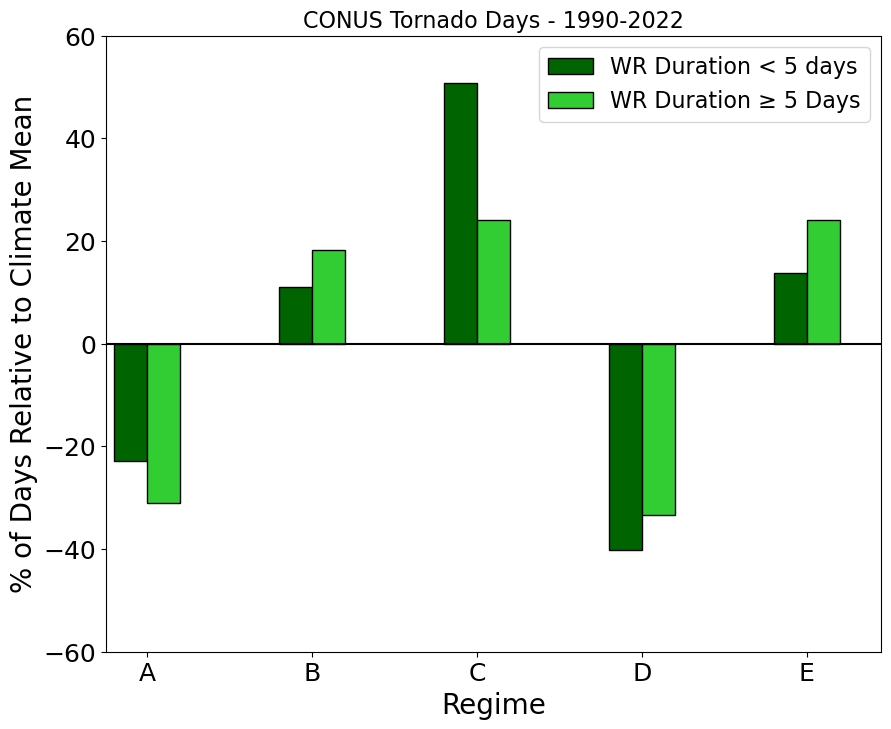

In [24]:
# Plot the tornado day probability anomalies
save = '/data/keeling/a/mgraber2/Course scripts/ATMS523/Module8/'
names = ['A','B','C', 'D','E']
days = [PA[0], PA[2], PA[4], PA[6], PA[8]] # EF-1+ non-persistent tornado days 
days5 = [PA[1], PA[3], PA[5], PA[7], PA[9]] # EF-1+ persistent tornado days
df = pd.DataFrame({'days':days, 'days5':days5})
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
df.days.plot(kind='bar', color='darkgreen', ax=axs, width = 0.2, edgecolor = 'black',position=1)
df.days5.plot(kind='bar', color='limegreen', ax=axs, width = 0.2, edgecolor = 'black', position=0)
axs.set_title(f'CONUS Tornado Days - 1990-2022', size='16')
axs.set_xlabel('Regime', size = '20')
axs.set_ylabel('% of Days Relative to Climate Mean', size = '20')
axs.set_ylim(-60,60)
axs.tick_params(axis='y', labelsize='18')
axs.set_xticklabels(names, rotation = 'horizontal', size='18')
axs.legend(labels =['WR Duration < 5 days', 'WR Duration ≥ 5 Days'], fontsize=16, loc = 1)
axs.axhline(0, color='black')
axs.grid(False)


In [26]:
# Compute model probabilities for purposes in the empirical model
model_probs = np.array(tornado_probabilities)/100
WR_A_pers = model_probs[0]
WR_A_npers = model_probs[1]
WR_B_pers = model_probs[2]
WR_B_npers = model_probs[3]
WR_C_pers = model_probs[4]
WR_C_npers = model_probs[5]
WR_D_pers = model_probs[6]
WR_D_npers = model_probs[7]
WR_E_pers = model_probs[8]
WR_E_npers = model_probs[9]

# Only on the ERA-5 Run
ERA5_1 = model_probs[0]
ERA5_2 = model_probs[1]
ERA5_3 = model_probs[2]
ERA5_4 = model_probs[3]
ERA5_5 = model_probs[4]
ERA5_6 = model_probs[5]
ERA5_7 = model_probs[6]
ERA5_8 = model_probs[7]
ERA5_9 = model_probs[8]
ERA5_10 = model_probs[9]

In [27]:
# Define the full range of years you want to account for
full_year_range = np.array([str(year) for year in range(1990, 2023)])

# Initialize a list to hold the year count dictionaries for each array
year_count_dicts = []
year_count_arrays = []

# Loop over each date array
for date_array in All_arrays:
    # Extract the year from each date (first 4 characters)
    years = np.array([date[:4] for date in date_array])
    
    # Count occurrences of each year
    unique_years, year_counts = np.unique(years, return_counts=True)
    
    # Create a dictionary to map each year to its count
    year_count_dict = dict(zip(unique_years, year_counts))
    
    # Add missing years (those that appear in full_year_range but not in unique_years) with a count of 0
    for year in full_year_range:
        if year not in year_count_dict:
            year_count_dict[year] = 0
    
    # Add the year count dictionary to the list
    year_count_dicts.append(year_count_dict)
    
    # Convert the dictionary to a numpy array (ordered by full_year_range)
    year_array = np.array([year_count_dict[year] for year in full_year_range])
    
    # Add the array to the list of arrays
    year_count_arrays.append(year_array)


WR_A_pers_freq = year_count_arrays[0]
WR_A_npers_freq = year_count_arrays[1]
WR_B_pers_freq = year_count_arrays[2]
WR_B_npers_freq = year_count_arrays[3]
WR_C_pers_freq = year_count_arrays[4]
WR_C_npers_freq = year_count_arrays[5]
WR_D_pers_freq = year_count_arrays[6]
WR_D_npers_freq = year_count_arrays[7]
WR_E_pers_freq = year_count_arrays[8]
WR_E_npers_freq = year_count_arrays[9]

## The model run below follows the methodology in Graber et al. 2025

In [28]:
# Model run 
WR_A = (WR_A_pers_freq *ERA5_1) + (WR_A_npers_freq*ERA5_2) 
WR_B = (WR_B_pers_freq *ERA5_3) + (WR_B_npers_freq*ERA5_4)
WR_C = (WR_C_pers_freq *ERA5_5) + (WR_C_npers_freq*ERA5_6)
WR_D = (WR_D_pers_freq *ERA5_7) + (WR_D_npers_freq*ERA5_8)
WR_E = (WR_E_pers_freq *ERA5_9) + (WR_E_npers_freq*ERA5_10)

TI = WR_A + WR_B + WR_C + WR_D + WR_E

np.save(f'{save}TI_TD.npy', TI)

In [29]:
# Filter out dates from 1989
tornado_date_array = tornado_date_array[~np.char.startswith(tornado_date_array, "1989")]

# Extract the year from each date
years = np.array([date[:4] for date in tornado_date_array])

# Define the range of years
full_year_range = np.array([str(year) for year in range(1990, 2023)])

# Initialize an array to store the count of days for each year
year_counts = np.zeros(len(full_year_range), dtype=int)

# Count occurrences of each year
for idx, year in enumerate(full_year_range):
    year_counts[idx] = np.sum(years == year)

TD_obs = year_counts

In [34]:
# Detrend the year-counts to account for the decreasing trend in tornado days
year_counts=detrend(year_counts,type = 'linear')

In [35]:
# Compute spearman rank correlation and p-value
cc, p = scipy.stats.spearmanr(year_counts, TI)

Text(0.5, 1.0, 'Modeled EF-1+ Days ERA-5')

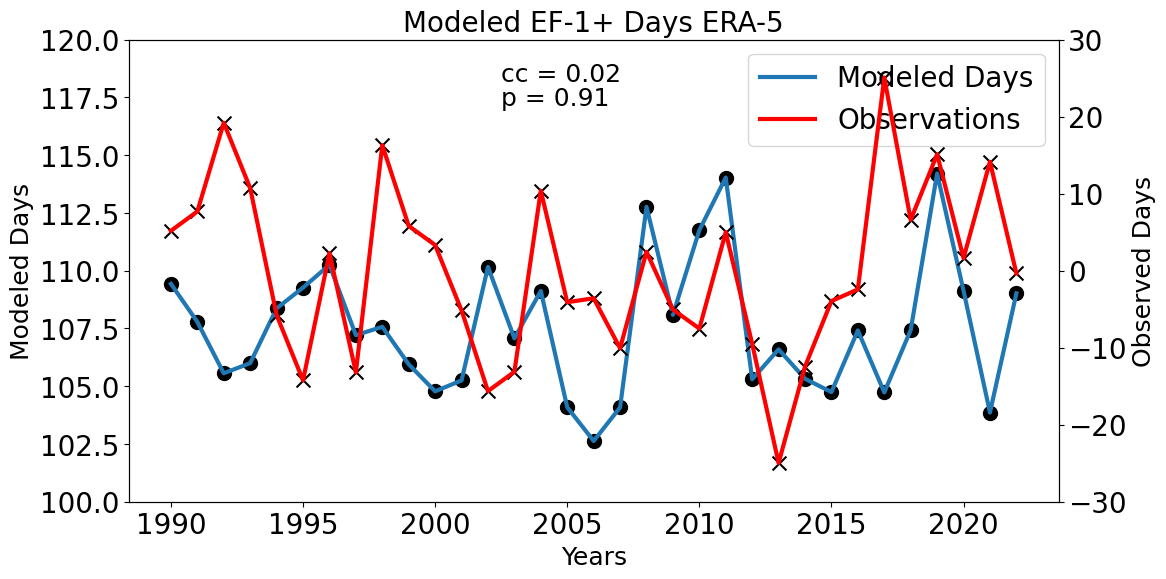

In [38]:
years = np.arange(1990,2023)
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(years, TI, label = 'Modeled Days', linewidth=3)
ax1.scatter(years, TI, color='black', s=100)
ax2.plot(years, year_counts, color='red', label = 'Observations', linewidth=3)
ax2.scatter(years, year_counts, marker='x', color='black', s=100)
ax1.tick_params(labelsize='20')
ax2.tick_params(labelsize='20')
ax1.set_xlabel('Years', size='18')
ax1.set_ylabel('Modeled Days', size='18')
ax2.set_ylabel('Observed Days', size='18')
ax1.set_ylim(100,120)
ax2.set_ylim(-30,30)
#ax2.set_yticks(np.arange(0,12.1,2))
ax1.text(.40, .95, f'cc = {cc:.2f}', ha='left', va='top', size=18, transform=ax1.transAxes)
ax1.text(.40, .9, f'p = {p:.2f}', ha='left', va='top', size=18, transform=ax1.transAxes)
ax1.grid(False)
ax2.grid(False)

# Combine the handles and labels from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=1, fontsize=20)
#ax1.legend(fontsize=20)
plt.title(f'Modeled EF-1+ Days ERA-5', size='20')
#plt.savefig(f'{save}ERA5_projection_TDmodel.png')

## Now do Tornado Outbreaks

In [48]:
# Define the start and end years
start_year = 1990
end_year = 2022

# Generate all dates in April and May for each year from 1981 to 2023
dates = []
for year in range(start_year, end_year + 1):
    january_dates = [dt.date(year, 1, day) for day in range(1, 32)]
    february_dates = [dt.date(year, 2, day) for day in range(1, 29)]
    march_dates = [dt.date(year, 3, day) for day in range(1, 32)]
    april_dates = [dt.date(year, 4, day) for day in range(1, 31)]
    may_dates = [dt.date(year, 5, day) for day in range(1, 32)]
    june_dates = [dt.date(year, 6, day) for day in range(1, 31)]
    july_dates = [dt.date(year, 7, day) for day in range(1, 32)]
    august_dates = [dt.date(year, 8, day) for day in range(1, 32)]
    september_dates = [dt.date(year, 9, day) for day in range(1, 31)]
    october_dates = [dt.date(year, 10, day) for day in range(1, 32)]
    november_dates = [dt.date(year, 11, day) for day in range(1, 31)]
    december_dates = [dt.date(year, 12, day) for day in range(1, 32)]
    dates.extend(january_dates + february_dates + march_dates + april_dates + may_dates + june_dates + july_dates + august_dates + september_dates + october_dates + november_dates + december_dates)

# Convert to formatted string array
date_array = np.array([date.strftime("%Y-%m-%d") for date in dates])

# Display results
print(date_array)

['1990-01-01' '1990-01-02' '1990-01-03' ... '2022-12-29' '2022-12-30'
 '2022-12-31']


In [49]:
# Set directory and collect CSV files
current_directory = os.chdir('/data/keeling/a/mgraber2/Data/SPCTOR_obs/ATMS523/')
csv_files = [file for file in os.listdir() if file.endswith('.csv')]

# Initialize a Counter to store tornado date counts
tornado_date_counts = Counter()

# Loop through each file and process the dates
for file in csv_files:
    data = pd.read_csv(file, parse_dates=['date'], dayfirst=False)
    data = data['date'].dt.date
    tornado_date_counts.update(data)

# Filter dates with more than 10 tornadoes
tornado_dates_10plus = [date for date, count in tornado_date_counts.items() if count > 10]

# Convert to a sorted numpy array and format dates as "YYYY-MM-DD"
tornado_outbreak_dates = np.array(sorted(date.strftime("%Y-%m-%d") for date in tornado_dates_10plus))

print(tornado_outbreak_dates)

['1990-02-10' '1990-03-13' '1990-04-25' '1990-04-27' '1990-05-16'
 '1990-05-24' '1990-05-30' '1990-06-01' '1990-06-02' '1990-06-07'
 '1990-06-16' '1990-10-18' '1990-12-21' '1991-03-21' '1991-03-22'
 '1991-03-27' '1991-03-29' '1991-04-09' '1991-04-12' '1991-04-26'
 '1991-11-19' '1992-05-11' '1992-06-15' '1992-06-16' '1992-06-17'
 '1992-07-12' '1992-08-26' '1992-11-03' '1992-11-21' '1992-11-22'
 '1993-02-21' '1993-05-06' '1993-05-07' '1993-06-07' '1993-06-08'
 '1993-06-30' '1993-08-06' '1993-09-13' '1994-03-27' '1994-04-15'
 '1994-04-26' '1994-06-26' '1994-06-27' '1994-07-27' '1994-08-16'
 '1994-11-27' '1995-05-07' '1995-05-09' '1995-05-13' '1995-05-18'
 '1995-05-27' '1995-06-08' '1995-11-07' '1995-11-11' '1996-03-18'
 '1996-04-15' '1996-04-19' '1996-04-20' '1996-04-21' '1996-05-08'
 '1996-05-26' '1996-07-19' '1996-09-16' '1996-10-26' '1996-11-07'
 '1997-01-24' '1997-03-01' '1997-03-28' '1997-05-27' '1997-07-01'
 '1997-07-02' '1997-07-03' '1997-10-23' '1998-03-29' '1998-04-16'
 '1998-05-

In [50]:
# Stack the arrays horizontally to create a 2D array
# Import the rearranged array containing the labels
labels = np.load('/data/keeling/a/mgraber2/Course scripts/ATMS523/Module8/labels.npy')
date_regime_array = np.column_stack((date_array, labels))

In [51]:
# Create an empty list to store the date arrays for each regime
regime_dates = []

# Iterate through each regime (0 to 4)
for regime in range(5):
    # Filter the array for dates where the regime number is 'regime'
    dates_for_regime = date_regime_array[date_regime_array[:, 1].astype(int) == regime, 0]
    
    # Append the filtered dates to the list
    regime_dates.append(dates_for_regime)

# Optionally, if you want to store these arrays in separate variables
regime_0_dates = regime_dates[0]
regime_1_dates = regime_dates[1]
regime_2_dates = regime_dates[2]
regime_3_dates = regime_dates[3]
regime_4_dates = regime_dates[4]

In [52]:
# Apply the persistent function to each regime
persistent_and_nonpersistent = {}

for i in range(5):
    # Assume each regime's dates are in regime_dates[i]
    regime_dates_array = regime_dates[i]
    
    # Find persistent and nonpersistent dates
    persistent, nonpersistent = find_consecutive_dates(regime_dates_array, min_consecutive=5)
    
    # Store the results in a dictionary for easy access later
    persistent_and_nonpersistent[f"Regime_{i}_persistent"] = persistent
    persistent_and_nonpersistent[f"Regime_{i}_nonpersistent"] = nonpersistent

In [53]:
# Make separate arrays
regimeA_pers = np.unique(np.array(persistent_and_nonpersistent['Regime_0_persistent']))
regimeA_npers = np.unique(np.array(persistent_and_nonpersistent['Regime_0_nonpersistent']))
regimeB_pers = np.unique(np.array(persistent_and_nonpersistent['Regime_1_persistent']))
regimeB_npers = np.unique(np.array(persistent_and_nonpersistent['Regime_1_nonpersistent']))
regimeC_pers = np.unique(np.array(persistent_and_nonpersistent['Regime_2_persistent']))
regimeC_npers = np.unique(np.array(persistent_and_nonpersistent['Regime_2_nonpersistent']))
regimeD_pers = np.unique(np.array(persistent_and_nonpersistent['Regime_3_persistent']))
regimeD_npers = np.unique(np.array(persistent_and_nonpersistent['Regime_3_nonpersistent']))
regimeE_pers = np.unique(np.array(persistent_and_nonpersistent['Regime_4_persistent']))
regimeE_npers = np.unique(np.array(persistent_and_nonpersistent['Regime_4_nonpersistent']))

In [59]:
# Combine all persistent and nonpersistent WR dates
persistent_dates = np.unique(
    np.concatenate([regimeA_pers, regimeB_pers, regimeC_pers, regimeD_pers, regimeE_pers])
)
nonpersistent_dates = np.unique(
    np.concatenate([regimeA_npers, regimeB_npers, regimeC_npers, regimeD_npers, regimeE_npers])
)

# Convert tornado_date_array and WR dates to numpy datetime objects for comparison
tornado_dates = np.array(tornado_outbreak_dates, dtype='datetime64[D]')
persistent_dates = np.array(persistent_dates, dtype='datetime64[D]')
nonpersistent_dates = np.array(nonpersistent_dates, dtype='datetime64[D]')

# Find intersection of tornado dates with persistent and nonpersistent WR dates
persistent_tornado_dates = np.intersect1d(tornado_dates, persistent_dates)
nonpersistent_tornado_dates = np.intersect1d(tornado_dates, nonpersistent_dates)

# Define the range of years explicitly
years = np.arange(1990, 2023) 

# Extract years and count occurrences
persistent_years = persistent_tornado_dates.astype('datetime64[Y]').astype(int) + 1970
nonpersistent_years = nonpersistent_tornado_dates.astype('datetime64[Y]').astype(int) + 1970

persistent_counts = Counter(persistent_years)
nonpersistent_counts = Counter(nonpersistent_years)

# Create time series
persistent_time_series = [persistent_counts.get(year, 0) for year in years]
nonpersistent_time_series = [nonpersistent_counts.get(year, 0) for year in years]

# Print results
print("Persistent Tornado Time Series:", persistent_time_series)
print("Nonpersistent Tornado Time Series:", nonpersistent_time_series)

print(np.sum(persistent_time_series))
print(np.sum(nonpersistent_time_series))

Persistent Tornado Time Series: [12, 5, 7, 5, 7, 6, 7, 3, 10, 10, 3, 9, 3, 8, 12, 7, 7, 6, 19, 10, 6, 11, 4, 3, 6, 11, 6, 8, 12, 11, 10, 9, 8]
Nonpersistent Tornado Time Series: [1, 3, 2, 3, 1, 2, 4, 5, 1, 0, 1, 2, 1, 6, 4, 2, 2, 3, 4, 1, 4, 9, 1, 9, 3, 2, 5, 13, 2, 10, 2, 4, 5]
261
117


In [60]:
# Compute tornado outbreak probabilities
All_arrays = [regimeA_npers, regimeA_pers, regimeB_npers, regimeB_pers, regimeC_npers, regimeC_pers, regimeD_npers, regimeD_pers, regimeE_npers, regimeE_pers]

# Initialize a list to store tornado probabilities for each array
tornado_probabilities = []

# Loop through each regime's date array and calculate tornado probability
for regime_dates in All_arrays:
    # Find common dates between regime dates and tornado dates
    common_dates = np.isin(regime_dates, tornado_outbreak_dates)
    
    # Count how many dates are common
    num_common_dates = np.sum(common_dates)
    
    # Calculate tornado probability (as a percentage)
    tornado_probability = (num_common_dates / len(regime_dates)) * 100
    
    # Store the tornado probability in the list
    tornado_probabilities.append(tornado_probability)

In [61]:
# Compute Pc and outbreak anomalies
Pc = len(tornado_outbreak_dates)/len(date_array) * 100

PA = []
for i in tornado_probabilities:
    anomaly = (i-Pc)/Pc * 100
    PA.append(anomaly)

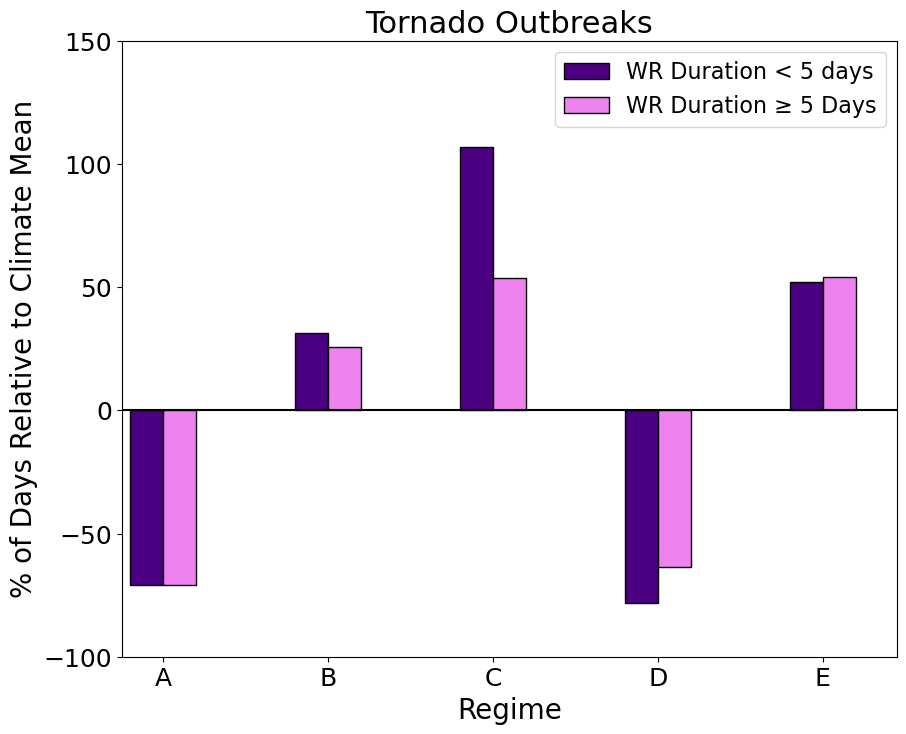

In [62]:
# Plot the anomalies
names = ['A','B','C', 'D','E']
days = [PA[0], PA[2], PA[4], PA[6], PA[8]] # EF-1+ non-persistent tornado days 
days5 = [PA[1], PA[3], PA[5], PA[7], PA[9]] # EF-1+ persistent tornado days
df = pd.DataFrame({'days':days, 'days5':days5})
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
df.days.plot(kind='bar', color='indigo', ax=axs, width = 0.2, edgecolor = 'black',position=1)
df.days5.plot(kind='bar', color='violet', ax=axs, width = 0.2, edgecolor = 'black', position=0)
axs.set_title(f"Tornado Outbreaks", size = '22')
axs.set_xlabel('Regime', size = '20')
axs.set_ylabel('% of Days Relative to Climate Mean', size = '20')
axs.set_ylim(-100,150)
axs.tick_params(axis='y', labelsize='18')
axs.set_xticklabels(names, rotation = 'horizontal', size='18')
axs.legend(labels =['WR Duration < 5 days', 'WR Duration ≥ 5 Days'], fontsize=16, loc = 1)
axs.axhline(0, color='black')
axs.grid(False)
#plt.savefig(f'{save}TO_probs_ERA5_projection.png')

In [63]:
# Compute model probabilities for empirical model
model_probs = np.array(tornado_probabilities)/100
WR_A_npers = model_probs[0]
WR_A_pers = model_probs[1]
WR_B_npers = model_probs[2]
WR_B_pers = model_probs[3]
WR_C_npers = model_probs[4]
WR_C_pers = model_probs[5]
WR_D_npers = model_probs[6]
WR_D_pers = model_probs[7]
WR_E_npers = model_probs[8]
WR_E_pers = model_probs[9]

# Only on the ERA-5 Run
ERA5_1 = model_probs[0]
ERA5_2 = model_probs[1]
ERA5_3 = model_probs[2]
ERA5_4 = model_probs[3]
ERA5_5 = model_probs[4]
ERA5_6 = model_probs[5]
ERA5_7 = model_probs[6]
ERA5_8 = model_probs[7]
ERA5_9 = model_probs[8]
ERA5_10 = model_probs[9]

In [64]:
# Define the full range of years you want to account for 
full_year_range = np.array([str(year) for year in range(1990, 2023)])

# Initialize a list to hold the year count dictionaries for each array
year_count_dicts = []
year_count_arrays = []

# Loop over each date array
for date_array in All_arrays:
    # Extract the year from each date (first 4 characters)
    years = np.array([date[:4] for date in date_array])
    
    # Count occurrences of each year
    unique_years, year_counts = np.unique(years, return_counts=True)
    
    # Create a dictionary to map each year to its count
    year_count_dict = dict(zip(unique_years, year_counts))
    
    # Add missing years (those that appear in full_year_range but not in unique_years) with a count of 0
    for year in full_year_range:
        if year not in year_count_dict:
            year_count_dict[year] = 0
    
    # Add the year count dictionary to the list
    year_count_dicts.append(year_count_dict)
    
    # Convert the dictionary to a numpy array (ordered by full_year_range)
    year_array = np.array([year_count_dict[year] for year in full_year_range])
    
    # Add the array to the list of arrays
    year_count_arrays.append(year_array)


WR_A_pers_freq = year_count_arrays[0]
WR_A_npers_freq = year_count_arrays[1]
WR_B_pers_freq = year_count_arrays[2]
WR_B_npers_freq = year_count_arrays[3]
WR_C_pers_freq = year_count_arrays[4]
WR_C_npers_freq = year_count_arrays[5]
WR_D_pers_freq = year_count_arrays[6]
WR_D_npers_freq = year_count_arrays[7]
WR_E_pers_freq = year_count_arrays[8]
WR_E_npers_freq = year_count_arrays[9]

In [65]:
# Model run
WR_A = (WR_A_pers_freq*ERA5_1) + (WR_A_npers_freq*ERA5_2)           
WR_B = (WR_B_pers_freq*ERA5_3) + (WR_B_npers_freq*ERA5_4)
WR_C = (WR_C_pers_freq*ERA5_5) + (WR_C_npers_freq*ERA5_6)
WR_D = (WR_D_pers_freq*ERA5_7) + (WR_D_npers_freq*ERA5_8)
WR_E = (WR_E_pers_freq*ERA5_9) + (WR_E_npers_freq*ERA5_10)

TI = WR_A + WR_B + WR_C + WR_D + WR_E

np.save(f'{save}TI_TO', TI)

In [66]:
# Filter out dates from 1989
tornado_outbreak_dates = tornado_outbreak_dates[~np.char.startswith(tornado_outbreak_dates, "1989")]

# Extract the year from each date (first 4 characters)
years = np.array([date[:4] for date in tornado_outbreak_dates])

# Define the range of years (1981-2023)
full_year_range = np.array([str(year) for year in range(1990, 2023)])

# Initialize an array to store the count of days for each year
year_counts = np.zeros(len(full_year_range), dtype=int)

# Count occurrences of each year
for idx, year in enumerate(full_year_range):
    year_counts[idx] = np.sum(years == year)

TO_obs = year_counts

In [71]:
# Detrend to remove the linear trend
year_counts=detrend(year_counts,type = 'linear')

In [72]:
# Compute spearman rank correlations and p-values
cc, p = scipy.stats.spearmanr(year_counts, TI)

Text(0.5, 1.0, 'Modeled Outbreak Days')

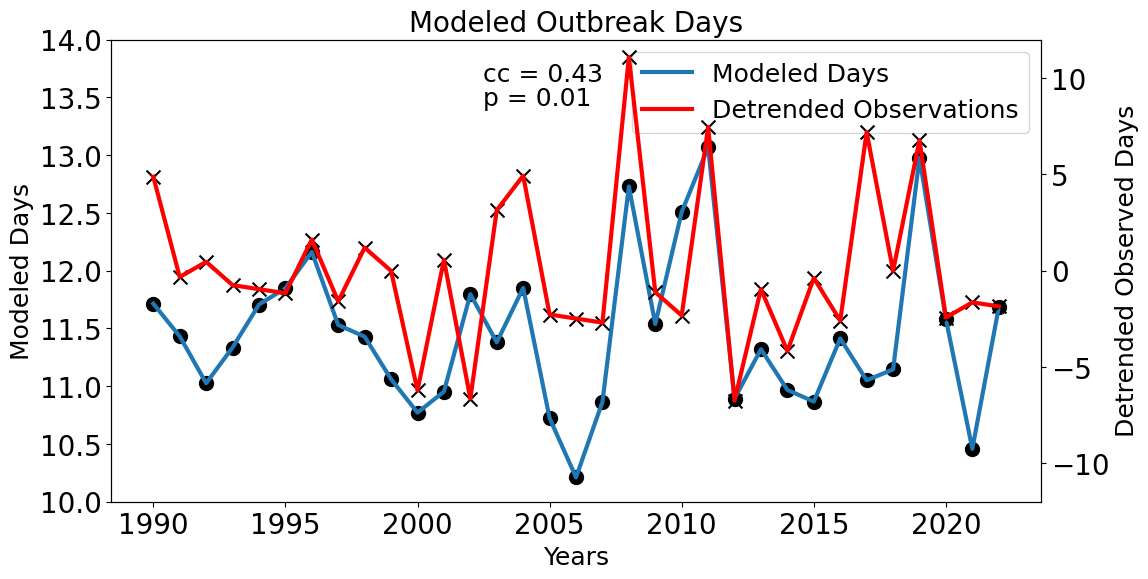

In [78]:
years = np.arange(1990,2023)
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.plot(years, TI, label = 'Modeled Days', linewidth=3)
ax1.scatter(years, TI, color='black', s=100)
ax2.plot(years, year_counts, color='red', label = 'Detrended Observations', linewidth=3)
ax2.scatter(years, year_counts, marker='x', color='black', s=100)
ax1.tick_params(labelsize='20')
ax2.tick_params(labelsize='20')
ax1.set_xlabel('Years', size='18')
ax1.set_ylabel('Modeled Days', size='18')
ax2.set_ylabel('Detrended Observed Days', size='18')
ax1.set_ylim(10,14)
ax2.set_ylim(-12,12)
#ax1.set_yticks(np.arange(0,15.1,5))
#ax2.set_xticks(np.arange(2,6.1,2))
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=1, fontsize=18)
ax1.text(.40, .95, f'cc = {cc:.2f}', ha='left', va='top', size=18, transform=ax1.transAxes)
ax1.text(.40, .9, f'p = {p:.2f}', ha='left', va='top', size=18, transform=ax1.transAxes)
ax1.grid(False)
#ax2.grid(False)

plt.title(f'Modeled Outbreak Days', size='20')
#plt.savefig(f'{save}Model_TO_ERA5_Projection.png')